In [1]:
import sys
sys.path.append("../..")

# Noisy Pendulum - Particle Filter Example

Estimate pendulum state with Particle Filter and Backward-simulation Particle Smoother as in Examples 7.1 and 11.1 of the book Bayesian Filtering and Smoothing


## Imports

### Standard imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg, stats
import tqdm

### Helpers imports

In [3]:
from python.common_utilities import generate_pendulum, RandomState, rmse, plot_pendulum

## Routine

Set the parameters:

In [4]:
dt = 0.01
g  = 9.81

In [5]:
Q  = 0.01 * np.array([[dt ** 3 / 3, dt ** 2 / 2], 
                       [dt ** 2 / 2, dt]])
R  = 0.1

In [6]:
x_0 = np.array([1.5, 0.])

## Simulate data

In [7]:
random_state = RandomState(1)
steps = 500

timeline, states, observations = generate_pendulum(x_0, g, Q, dt, R, steps, random_state)

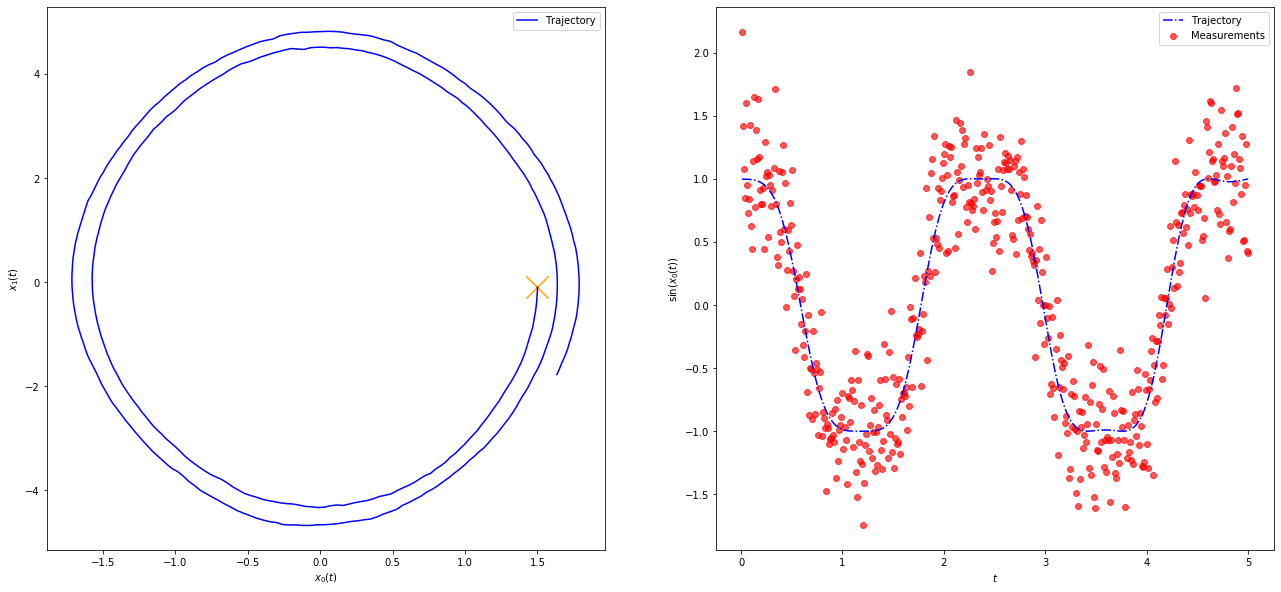

In [8]:
plot_pendulum(timeline, observations, states, "Trajectory")

## Particle Filter

In [12]:
m_0 = np.array([1.6, 0.])  # Slightly off
P_0 = np.array([[0.1, 0.], 
                [0., 0.1]])

In [13]:
def stratified_resampling(w, random_state):
    """ Generate non decreasing numbers x_i between [0, 1]
    """
    n_particles = w.shape[0]
    z = random_state.rand(n_particles) + np.linspace(0., n_particles - 1., n_particles)
    us = z / n_particles
    cs = np.cumsum(w)
    idx = np.searchsorted(cs, us, side='left')

    return np.clip(idx, 0, n_particles - 1)


In [14]:
def normalise(w):
    """Normalises the positive vector w so that it sums to 1"""
    return w / np.sum(w, axis=-1, keepdims=True)

In [15]:
def particle_filter(m_0, P_0, g, Q, dt, R, observations, n_particles, random_state):
    steps = observations.shape[0]
    
    pf_states = np.empty((steps, 2, n_particles))
    
    chol_P0 = np.linalg.cholesky(P_0)
    chol_Q = np.linalg.cholesky(Q)
    state = m_0.reshape(2, 1) + np.matmul(chol_P0, random_state.randn(2, n_particles))
    
    w = np.full(n_particles, 1/n_particles)
    sqrt_R = np.sqrt(R)
    
    observation_dist = stats.norm(loc=0., scale=sqrt_R)
    ll = 0
    for i in range(steps):
        # Propagate through the dynamic model: cross-term update
        state[0, :], state[1, :] = state[0, :] + dt * state[1, :], state[1, :] - g * dt * np.sin(state[0, :])
        
        # Add the process noise
        state = state + np.matmul(chol_Q, random_state.randn(2, n_particles))

        # Compute the unnormalized importance weights
        obs = observations[i]
        w = observation_dist.pdf(obs - np.sin(state[0, :]))

        ll += np.log(np.mean(w))
        # Normalize them
        w = normalise(w)
        
        # Do resampling
        ind = stratified_resampling(w, random_state)
        state = state[:, ind]
        pf_states[i] = state
        
    return pf_states

In [17]:
n_particles = 1000
filtered_states = particle_filter(m_0, P_0, g, Q, dt, R, observations, n_particles, random_state)
print(filtered_states)

[[[ 1.7354872   1.7354872   1.83072804 ...  1.48677115  1.48677115
    1.59828707]
  [ 0.13002981  0.13002981 -0.52011654 ...  0.08582251  0.08582251
    0.30305753]]

 [[ 1.7368052   1.73674412  1.82555854 ...  1.48760689  1.48761427
    1.60137281]
  [ 0.0333817   0.01985815 -0.60703506 ... -0.02097889 -0.01058117
    0.20763295]]

 [[ 1.73714833  1.73693197  1.81947274 ...  1.48741799  1.48750075
    1.60336822]
  [-0.06047492 -0.07910037 -0.70861581 ... -0.1209083  -0.11381749
    0.09475707]]

 ...

 [[ 1.74915648  1.78948239  1.6504779  ...  1.70759071  1.70750933
    1.7358999 ]
  [-1.12080003 -1.04687509 -1.3985983  ... -1.3691892  -1.3838264
   -1.31120491]]

 [[ 1.73806226  1.77895942  1.63652774 ...  1.69401165  1.69363954
    1.72271276]
  [-1.20048079 -1.15155339 -1.49938112 ... -1.45468532 -1.48547739
   -1.41970151]]

 [[ 1.72608476  1.76736126  1.62149078 ...  1.67945852  1.67874366
    1.70851191]
  [-1.29358852 -1.25753066 -1.60528643 ... -1.55120184 -1.59204452
   -1

In [19]:
pf_m = np.mean(filtered_states, axis=-1)
print(pf_m)

[[ 1.58648569e+00 -1.01357437e-01]
 [ 1.58599505e+00 -1.99813220e-01]
 [ 1.58388377e+00 -2.94482706e-01]
 [ 1.57829960e+00 -3.88799556e-01]
 [ 1.57560750e+00 -4.85392157e-01]
 [ 1.57137640e+00 -5.81098695e-01]
 [ 1.56218252e+00 -6.84819986e-01]
 [ 1.55443657e+00 -7.70947273e-01]
 [ 1.55435348e+00 -8.71312432e-01]
 [ 1.54354802e+00 -9.75286903e-01]
 [ 1.52584734e+00 -1.06988032e+00]
 [ 1.51967774e+00 -1.16603797e+00]
 [ 1.52420233e+00 -1.26003930e+00]
 [ 1.51002135e+00 -1.35122444e+00]
 [ 1.50683279e+00 -1.44963674e+00]
 [ 1.49515087e+00 -1.54527065e+00]
 [ 1.49494795e+00 -1.63241610e+00]
 [ 1.48349677e+00 -1.71558099e+00]
 [ 1.46759491e+00 -1.80648808e+00]
 [ 1.44277351e+00 -1.90676187e+00]
 [ 1.41832585e+00 -2.00587332e+00]
 [ 1.39732903e+00 -2.10151210e+00]
 [ 1.35445767e+00 -2.20821282e+00]
 [ 1.35081633e+00 -2.29524849e+00]
 [ 1.33307885e+00 -2.38690647e+00]
 [ 1.31787403e+00 -2.47871423e+00]
 [ 1.26805236e+00 -2.59083214e+00]
 [ 1.25073787e+00 -2.67922849e+00]
 [ 1.22735518e+00 -2

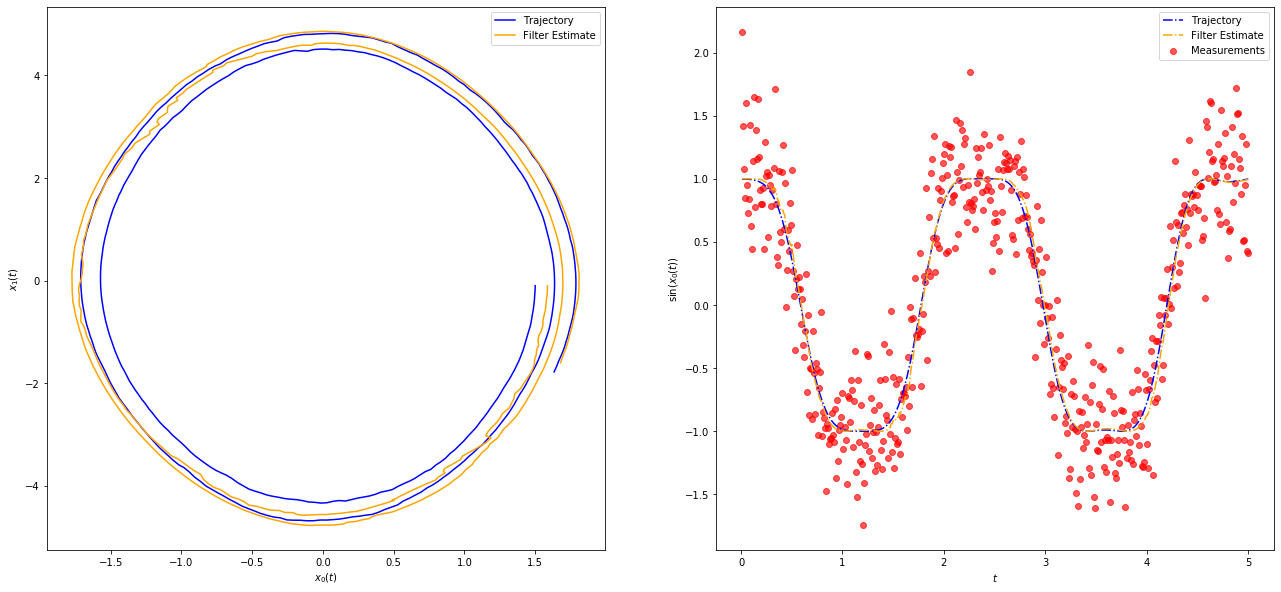

In [20]:
plot_pendulum(timeline, observations, states, "Trajectory", pf_m, "Filter Estimate")

In [21]:
rmse_pf = rmse(pf_m[:, :1], states[:, :1])
print(f"PF RMSE: {rmse_pf}")

PF RMSE: 0.0915000618035571


## Particle Smoother

In [17]:
def particle_smoother(pf_states, g, Q, dt, R, n_trajectories, random_state):
    steps, M, n_particles = pf_states.shape
    pf_bs_states = np.empty((steps, 2, n_trajectories))
    
    ind = random_state.choice(n_particles, n_trajectories)
    smoothed_states = pf_states[-1][:, ind]
    pf_bs_states[-1] = smoothed_states
    
    frozen_dist = stats.multivariate_normal(mean=[0., 0.], cov=Q)
    
    for i in tqdm.trange(steps-2, -1, -1):
        filtered_state = pf_states[i]
        mu = np.stack([filtered_state[0, :] + filtered_state[1, :] * dt,
                       filtered_state[1, :] - g * np.sin(filtered_state[0, :]) * dt], axis=1)
        for k in range(n_trajectories):
            smoothed_state = smoothed_states[:, k]
            diff = smoothed_state.reshape(1, M) - mu
            w = frozen_dist.pdf(diff)
            w = normalise(w)
            ind = random_state.choice(n_particles, 1, p=w)
            smoothed_state = filtered_state[:, ind].flatten()
            smoothed_states[:, k] = smoothed_state
            pf_bs_states[i, :, k] = smoothed_state
            
    return pf_bs_states

In [18]:
pf_bs_states = particle_smoother(filtered_states, g, Q, dt, R, 100, random_state)

100%|██████████| 499/499 [00:04<00:00, 113.75it/s]


In [19]:
pf_bs_m = np.mean(pf_bs_states, axis=-1)

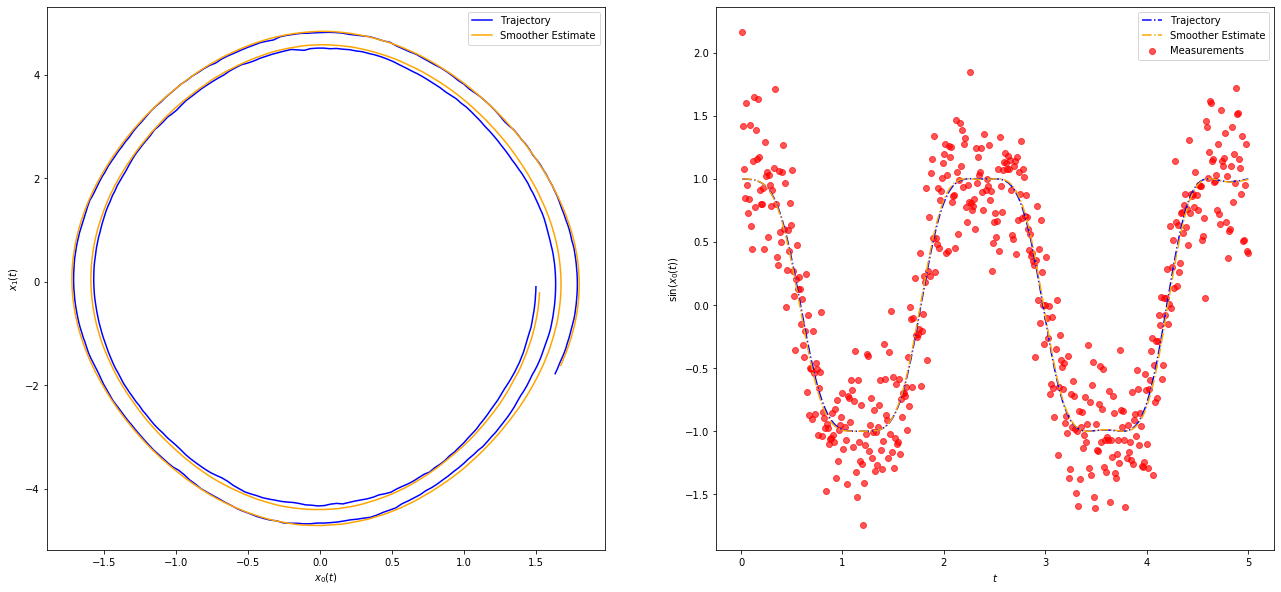

In [20]:
plot_pendulum(timeline, observations, states, "Trajectory", pf_bs_m, "Smoother Estimate")

In [21]:
rmse_pf_bs = rmse(pf_bs_m[:, :1], states[:, :1])
print(f"PF-BS RMSE: {rmse_pf_bs}")

PF-BS RMSE: 0.030590265720468888
